Reference: kaggle 

In [48]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

import tensorflow as tf

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

%matplotlib inline

In [49]:
images_folder = './img/'
labels = 'labels.csv'

TRAINING_SAMPLES = 3200
VALIDATION_SAMPLES = 800
TEST_SAMPLES = 1000

IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

(218, 178, 3)

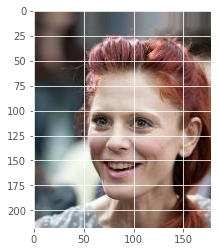

In [50]:
EXAMPLE_PIC = images_folder + '1.jpg'
im = plt.imread(EXAMPLE_PIC)
plt.imshow(im)
im.shape

In [51]:
df = pd.read_csv(labels, sep='\s+')
df.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df.shape

(5000, 3)

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.img_name, df.smiling, test_size= 0.2, random_state=0,stratify=df.smiling)
X_train, X_val,y_train,y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0,stratify=y_train)

print(X_train.shape, X_val.shape,X_test.shape)

(3200,) (800,) (1000,)


In [53]:
partition = []
for x in range(5000):
    if x in X_train:
        partition.append('0')
    elif x in X_val:
        partition.append('1')
    else:
        partition.append('2')
df['partition'] = partition

In [54]:
train = 0
val = 0
test = 0
for x in partition:
    if x == '0':
        train += 1
    if x == '1':
        val += 1
    if x == '2':
        test += 1
print(train,val,test)

3200 800 1000


In [55]:
#df_par_attr = df.drop('smiling',axis=1)
df.set_index('img_name', inplace=True)
df_par_attr = df.copy()
#df_par_attr.set_index('img_name', inplace=True)

In [56]:
df_par_attr.smiling.value_counts()

1    2500
0    2500
Name: smiling, dtype: int64

In [57]:
df_par_attr.gender.value_counts()

1    2500
0    2500
Name: gender, dtype: int64

In [58]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

def gen_df(partition,attr,num_samples):
    df_ = df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_, df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    if partition != '2':
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])
    return x_, y_

In [59]:
x_train,y_train = gen_df('0','smiling',3200)
x_val,y_val = gen_df('1','smiling',800)
x_test,y_test = gen_df('2','smiling',1000)

In [60]:
# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [61]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [62]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [67]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:311]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [68]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.smile.hdf5', 
                               verbose=1, save_best_only=True)

In [69]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_val, y_val)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= 15
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/15
200/200 [==============================] - 323s 2s/step - loss: 0.7101 - accuracy: 0.5216 - val_loss: 0.7095 - val_accuracy: 0.5250

Epoch 00001: val_loss improved from inf to 0.70954, saving model to weights.best.inc.smile.hdf5
Epoch 2/15
200/200 [==============================] - 314s 2s/step - loss: 0.6994 - accuracy: 0.5378 - val_loss: 0.7291 - val_accuracy: 0.5350

Epoch 00002: val_loss did not improve from 0.70954
Epoch 3/15
200/200 [==============================] - 314s 2s/step - loss: 0.6887 - accuracy: 0.5562 - val_loss: 0.7071 - val_accuracy: 0.5550

Epoch 00003: val_loss improved from 0.70954 to 0.70714, saving model to weights.best.inc.smile.hdf5
Epoch 4/15
200/200 [==============================] - 337s 2s/step - loss: 0.6740 - accuracy: 0.5894 - val_loss: 0.7100 - val_accuracy: 0.5663

Epoch 00004: val_loss did not improve from 0.70714
Epoch 5/15
200/200 [==============================] - 307s 2s/step - loss: 0.6667 - accuracy: 0.6037 - val_loss: 0.6946 - val_

KeyboardInterrupt: 

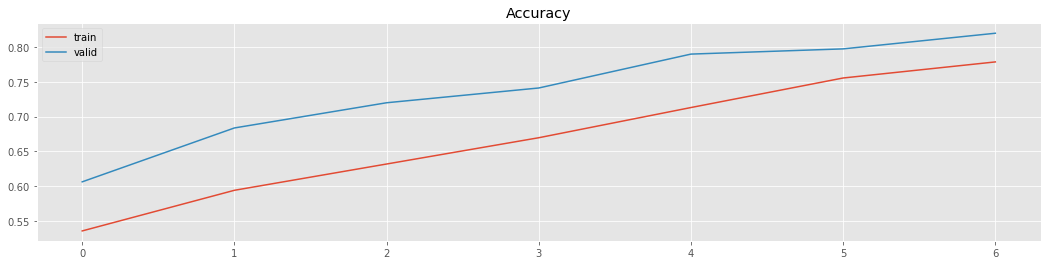

In [70]:
# Plot accuracy through epochs no learn any layer
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

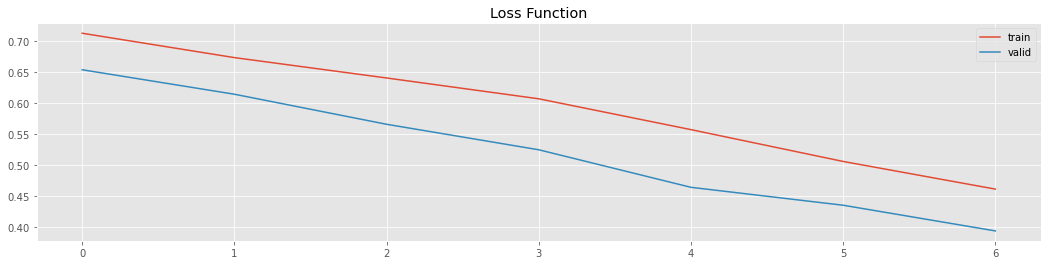

In [45]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

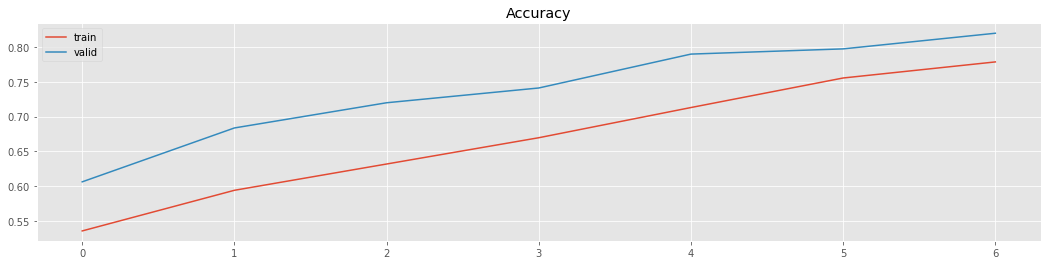

In [46]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [47]:
# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 80.8000%
f1_score: 0.8020618556701031
